In [4]:
import pandas as pd
import numpy as np
import re
from unicodedata import normalize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
ds = pd.read_csv('/content/drive/MyDrive/AI/dataset/diploma/NLP/ara.csv', sep='\t', names=['English', 'Arabic', 'Attribution'])
ds.head()

,English,Arabic,Attribution
0,Hi.,مرحبًا.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
1,Run!,اركض!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
2,Duck!,اخفض رأسك!,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Duck!,اخفضي رأسك!,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
4,Duck!,اخفضوا رؤوسكم!,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [7]:
df = ds.sample(frac=1, random_state=42).reset_index(drop=True)
df.head(10)

,English,Arabic,Attribution
0,Do you have a friend named Tom?,هل لديك صديق يسمى توم ؟,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
1,She called me in the afternoon.,اتصلت بي بعد الظهر.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
2,I had nothing else to do.,لم يكن لديّ أيّ شيء آخر أقوم به.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,I said I would make her happy.,قلتُ أني سأسعدها.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
4,He asked us to help him.,طلب منا المساعدة.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
5,All of us should go.,علينا جميعا أن نذهب.,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
6,That was years ago.,حصل ذلك منذ سنوات عدة.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
7,The doctor took his pulse.,قاس الطبيب نبضه.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
8,This story is based on a true story.,هذه القصة مُستمّدة من قصّةٍ واقعية.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
9,What are you up to tomorrow afternoon?,ماذا عندك بعد ظهر غد؟,CC-BY 2.0 (France) Attribution: tatoeba.org #6...


In [8]:
ds = ds[['English', 'Arabic']]
ds.head(2)

,English,Arabic
0,Hi.,مرحبًا.
1,Run!,اركض!


In [9]:
def clean_text(text):
    """Clean and normalize text"""
    text = normalize('NFD', str(text).lower())
    text = re.sub('[^a-z ]+', '', text)
    return text.strip()

def clean_arabic(text):
    """Clean Arabic text - preserve Arabic characters"""
    text = str(text).strip()
    # Remove extra whitespaces but keep Arabic characters
    text = re.sub(r'\s+', ' ', text)
    return text

In [10]:

df['English'] = df['English'].apply(clean_text)
df['Arabic'] = df['Arabic'].apply(clean_arabic)

# Remove empty strings
df = df[(df['English'].str.len() > 0) & (df['Arabic'].str.len() > 0)]

print(f"Dataset size: {len(df)} sentence pairs")
print(f"Sample English: {df['English'].iloc[1]}")
print(f"Sample Arabic: {df['Arabic'].iloc[1]}")

Dataset size: 12561 sentence pairs
Sample English: she called me in the afternoon
Sample Arabic: اتصلت بي بعد الظهر.


In [11]:
df.head(10)

,English,Arabic,Attribution
0,do you have a friend named tom,هل لديك صديق يسمى توم ؟,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
1,she called me in the afternoon,اتصلت بي بعد الظهر.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
2,i had nothing else to do,لم يكن لديّ أيّ شيء آخر أقوم به.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,i said i would make her happy,قلتُ أني سأسعدها.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
4,he asked us to help him,طلب منا المساعدة.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
5,all of us should go,علينا جميعا أن نذهب.,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
6,that was years ago,حصل ذلك منذ سنوات عدة.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
7,the doctor took his pulse,قاس الطبيب نبضه.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
8,this story is based on a true story,هذه القصة مُستمّدة من قصّةٍ واقعية.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
9,what are you up to tomorrow afternoon,ماذا عندك بعد ظهر غد؟,CC-BY 2.0 (France) Attribution: tatoeba.org #6...


In [12]:
# -------------------------------
# 2. Prepare Arabic with special tokens
# -------------------------------
# Add START and END tokens to Arabic sentences
START_TOKEN = '<start>'
END_TOKEN = '<end>'

# Create Arabic sentences with tokens
ar_with_tokens = df['Arabic'].apply(lambda x: f"{START_TOKEN} {x} {END_TOKEN}")
print(f"Sample Arabic with tokens: {ar_with_tokens.iloc[0]}")

Sample Arabic with tokens: <start> هل لديك صديق يسمى توم ؟ <end>


In [13]:
# Calculate max lengths
en_max_len = max(len(s.split()) for s in df['English'])
ar_max_len = max(len(s.split()) for s in ar_with_tokens)

print(f"English max length: {en_max_len}")
print(f"Arabic max length: {ar_max_len}")

English max length: 34
Arabic max length: 38


In [14]:
# -------------------------------
# 3. Tokenization & Padding
# -------------------------------
def tokenize_texts(texts):
    tokenizer = Tokenizer(filters='') # filters='' ensures no characters are removed
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    return tokenizer, sequences


en_tokenizer, en_seq = tokenize_texts(df['English'])
en_pad = pad_sequences(en_seq, maxlen=en_max_len, padding='post')
print(en_pad)

ar_tokenizer, ar_seq = tokenize_texts(ar_with_tokens)
ar_pad = pad_sequences(ar_seq, maxlen=ar_max_len, padding='post')

# Ensure START and END tokens are in the Arabic tokenizer vocabulary
START_TOKEN = '<START>'
END_TOKEN = '<END>'

# Add START and END tokens if they are not already in the vocabulary
# This might happen if they didn't appear in ar_with_tokens for some reason
# although the code adding them seems correct.
# Check if START_TOKEN is in word_index, if not, assign it the next available index
if START_TOKEN not in ar_tokenizer.word_index:
    current_index = len(ar_tokenizer.word_index) + 1
    ar_tokenizer.word_index[START_TOKEN] = current_index
    ar_tokenizer.index_word[current_index] = START_TOKEN
    print(f"Added {START_TOKEN} to Arabic tokenizer vocabulary at index {current_index}")

# Check if END_TOKEN is in word_index, if not, assign it the next available index
if END_TOKEN not in ar_tokenizer.word_index:
    current_index = len(ar_tokenizer.word_index) + 1
    ar_tokenizer.word_index[END_TOKEN] = current_index
    ar_tokenizer.index_word[current_index] = END_TOKEN
    print(f"Added {END_TOKEN} to Arabic tokenizer vocabulary at index {current_index}")



[[   9    2   17 ...    0    0    0]
 [  25  458   10 ...    0    0    0]
 [   1   95  202 ...    0    0    0]
 ...
 [   9    2   78 ...    0    0    0]
 [ 211    5  633 ...    0    0    0]
 [  89  441 1122 ...    0    0    0]]
Added <START> to Arabic tokenizer vocabulary at index 15598
Added <END> to Arabic tokenizer vocabulary at index 15599


In [15]:
# Vocabulary sizes (Recalculate after potentially adding tokens)
en_vocab_size = len(en_tokenizer.word_index) + 1 # +1 for padding token 0
ar_vocab_size = len(ar_tokenizer.word_index) + 1 # +1 for padding token 0

print(f"English vocabulary size: {en_vocab_size}")
print(f"Arabic vocabulary size: {ar_vocab_size}")

English vocabulary size: 4362
Arabic vocabulary size: 15600


In [16]:
from sklearn.model_selection import train_test_split
# Split the preprocessed text data (lists of strings)
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    ar_pad, en_pad, test_size=0.2, random_state=42
)

print(f"Length of X_train_text: {len(X_train_text)}")
print(f"Length of X_test_text: {len(X_test_text)}")
print(f"Length of y_train_text: {len(y_train_text)}")
print(f"Length of y_test_text: {len(y_test_text)}")

Length of X_train_text: 10048
Length of X_test_text: 2513
Length of y_train_text: 10048
Length of y_test_text: 2513


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Add, Activation, Dot, Concatenate, Dense, Dropout, Embedding, LSTM, Input
from tensorflow.keras.models import Model

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape will be a list: [encoder_outputs_shape, decoder_lstm_output_shape]
        # encoder_outputs_shape: (None, en_max_len, encoder_hidden_size)
        # decoder_lstm_output_shape: (None, ar_max_len-1, decoder_hidden_size)
        encoder_hidden_size = input_shape[0][-1]
        decoder_hidden_size = input_shape[1][-1]

        self.W1 = self.add_weight(name='W1',
                                  shape=(encoder_hidden_size, encoder_hidden_size),
                                  initializer='uniform',
                                  trainable=True)
        self.W2 = self.add_weight(name='W2',
                                  shape=(decoder_hidden_size, encoder_hidden_size),
                                  initializer='uniform',
                                  trainable=True)
        self.V = self.add_weight(name='V',
                                 shape=(encoder_hidden_size, 1),
                                 initializer='uniform',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        encoder_outputs, decoder_outputs = inputs # encoder_outputs: (batch, en_len, enc_hid), decoder_outputs: (batch, ar_len, dec_hid)

        scores = tf.tanh(tf.expand_dims(tf.matmul(decoder_outputs, self.W2), axis=2) + tf.expand_dims(tf.matmul(encoder_outputs, self.W1), axis=1)) # (batch, ar_len, en_len, enc_hid)
        scores = tf.matmul(scores, self.V) # (batch, ar_len, en_len, enc_hid) * (enc_hid, 1) -> (batch, ar_len, en_len, 1)
        scores = tf.squeeze(scores, axis=-1) # (batch, ar_len, en_len)

        attention_weights = tf.nn.softmax(scores, axis=-1) # (batch, ar_len, en_len) - sum over encoder timesteps for each decoder timestep

        # Context vector for each decoder timestep: c_t = sum_i(alpha_ti * s_i)
        # attention_weights: (batch, ar_len, en_len)
        # encoder_outputs: (batch, en_len, enc_hid)
        # We need to multiply (batch, ar_len, en_len) by (batch, en_len, enc_hid) -> (batch, ar_len, enc_hid)
        context_vector = tf.matmul(attention_weights, encoder_outputs) # (batch, ar_len, enc_hid)

        # The shape of context_vector is (batch, ar_len, enc_hid).
        # It should match the shape of decoder_outputs (batch, ar_len, dec_hid) along batch and sequence length dimensions
        # so they can be concatenated along the last axis, provided enc_hid + dec_hid makes sense for the next layer.
        # In our case, enc_hid (256) + dec_hid (256) = 512. The Dense layer input is 512.

        return context_vector, attention_weights

    def compute_output_shape(self, input_shape):
        # input_shape will be a list: [encoder_outputs_shape, decoder_lstm_output_shape]
        # encoder_outputs_shape: (None, en_max_len, encoder_hidden_size)
        # decoder_lstm_output_shape: (None, ar_max_len-1, decoder_hidden_size)
        encoder_sequence_length = input_shape[0][1]
        encoder_hidden_size = input_shape[0][-1]
        decoder_sequence_length = input_shape[1][1]

        # Context vector shape: (batch_size, decoder_sequence_length, encoder_hidden_size)
        context_shape = (input_shape[0][0], decoder_sequence_length, encoder_hidden_size)
        # Attention weights shape: (batch_size, decoder_sequence_length, encoder_sequence_length)
        weights_shape = (input_shape[0][0], decoder_sequence_length, encoder_sequence_length)

        return context_shape, weights_shape

In [18]:
# -------------------------------
# 5. Define Seq2Seq Model with Teacher Forcing and Attention
# -------------------------------
# Encoder
encoder_input = Input(shape=(en_max_len,), name='encoder_input')
encoder_embed = Embedding(
    input_dim=en_vocab_size,
    output_dim=300,
    input_length=en_max_len,
    mask_zero=False,
    name='encoder_embedding'
)(encoder_input)

encoder_lstm = LSTM(256, return_sequences=True, return_state=True, name='encoder_lstm') # return_sequences=True is needed for attention
encoder_output, state_h, state_c = encoder_lstm(encoder_embed)
encoder_states = [state_h, state_c]

# Decoder
decoder_input = Input(shape=(ar_max_len - 1,), name='decoder_input')
decoder_embed = Embedding(
    input_dim=ar_vocab_size,
    output_dim=300,
    mask_zero=False,
    name='decoder_embedding'
)(decoder_input)


decoder_lstm = LSTM(256, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_embed, initial_state=encoder_states)

# Attention layer
# Passes encoder_output (all timesteps) and decoder_outputs (all timesteps) to attention
attention = Attention(name='attention_layer')
context_vector, attention_weights = attention([encoder_output, decoder_outputs]) # context_vector should now be (batch, ar_len, enc_hid)

# Concatenate context vector and decoder output
# decoder_outputs: (batch, ar_len, dec_hid)
# context_vector:  (batch, ar_len, enc_hid)
# Concatenating along axis=-1 results in (batch, ar_len, dec_hid + enc_hid)
decoder_combined_context = Concatenate(axis=-1, name='concat_context_decoder_output')([decoder_outputs, context_vector])

# Add dropout
decoder_dropout = Dropout(0.3)(decoder_combined_context)

# Output layer
# Apply Dense layer time-distributed to output probability distribution for each timestep
decoder_dense = Dense(ar_vocab_size, activation='softmax', name='decoder_output')
# TimeDistributed wrapper is implicitly handled by Keras when applying Dense to a tensor with >2 dimensions
decoder_output = decoder_dense(decoder_dropout)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
# Training model
model = Model(inputs=[encoder_input, decoder_input], outputs=decoder_output)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Training Model with Attention Summary:")
model.summary()

Training Model with Attention Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 34, 300)   │  1,308,600 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 37, 300)   │  4,680,000 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 34, 256), │    570,368 │ encoder_embeddin… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 37, 256), │    570,368 │ decoder_embeddin… │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, 37, 256), │    131,328 │ encoder_lstm[0][… │
│ (Attention)         │ (None, 37, 34)]   │            │ decoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_context_dec… │ (None, 37, 512)   │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 37, 512)   │          0 │ concat_context_d… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output      │ (None, 37, 15600) │  8,002,800 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,263,464 (58.23 MB)

 Trainable params: 15,263,464 (58.23 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# -------------------------------
# 6. Prepare Data for Teacher Forcing
# -------------------------------
# Decoder input: all tokens except the last one
decoder_input_data = ar_pad[:, :-1]
# Decoder target: all tokens except the first one (shifted by 1)
decoder_target_data = ar_pad[:, 1:]
# Reshape target for sparse_categorical_crossentropy
decoder_target_data = np.expand_dims(decoder_target_data, -1)

print(f"Encoder input shape: {en_pad.shape}")
print(f"Decoder input shape: {decoder_input_data.shape}")
print(f"Decoder target shape: {decoder_target_data.shape}")

Encoder input shape: (12561, 34)
Decoder input shape: (12561, 37)
Decoder target shape: (12561, 37, 1)


In [21]:
# -------------------------------
# 7. Train Model
# -------------------------------
callback = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print("Starting training...")
hist = model.fit(
    [en_pad, decoder_input_data],
    decoder_target_data,
    batch_size=64,
    epochs=30,
    validation_split=0.2,
    callbacks=[callback],
    verbose=1
)

Starting training...
Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 124ms/step - accuracy: 0.8328 - loss: 2.5799 - val_accuracy: 0.8830 - val_loss: 1.0106
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.8834 - loss: 0.9598 - val_accuracy: 0.8838 - val_loss: 0.9978
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.8848 - loss: 0.9131 - val_accuracy: 0.8837 - val_loss: 1.0031
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.8860 - loss: 0.8836 - val_accuracy: 0.8823 - val_loss: 0.9992
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.8879 - loss: 0.8440 - val_accuracy: 0.8839 - val_loss: 0.9938
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.8893 - loss: 0.8130 - val_accuracy: 0.8855 - val_loss: 0.9853
Epoch 7/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.8919 - loss: 0.7691 - val_accuracy: 0.8868 - val_loss: 0.9773
Epoch 8/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accur

In [22]:
# Inference encoder model
encoder_model = Model(encoder_input, [encoder_output, state_h, state_c])

# Get the layers from training model for inference
decoder_embed_layer = model.get_layer('decoder_embedding')
decoder_lstm_layer = model.get_layer('decoder_lstm')
attention_layer_inf = model.get_layer('attention_layer') # Get the attention layer
concat_layer_inf = model.get_layer('concat_context_decoder_output') # Get the concatenate layer
# Corrected layer name based on the actual name in the trained model
dropout_layer_inf = model.get_layer('dropout') # Get the dropout layer if used before dense - Corrected name to 'dropout'
decoder_dense_layer = model.get_layer('decoder_output')

# Single timestep decoder input for inference
decoder_input_single = Input(shape=(1,))
decoder_embed_output = decoder_embed_layer(decoder_input_single)

# The decoder LSTM in inference needs initial state from encoder
# You need to define decoder_states_inputs. This should be the input tensor for the initial states.
# Assuming the decoder LSTM takes two state inputs (h and c)
decoder_states_inputs = [Input(shape=(256,), name='state_h_input'), Input(shape=(256,), name='state_c_input')]


decoder_output_inf_lstm, state_h_inf, state_c_inf = decoder_lstm_layer(
    decoder_embed_output, initial_state=decoder_states_inputs
)
decoder_states = [state_h_inf, state_c_inf]

# For inference, the attention layer also needs the encoder output from the current step.
# This means you need to pass the encoder output tensor as an input to the decoder model.
# The encoder output from the encoder_model prediction needs to be an input tensor here.
encoder_output_inf = Input(shape=(en_max_len, 256), name='encoder_output_input_inf') # Assuming encoder_hidden_size is 256

# Compute attention for the current decoder timestep
# Pass encoder_output along with the current decoder LSTM output (single timestep)
context_vector_inf, _ = attention_layer_inf([encoder_output_inf, decoder_output_inf_lstm])

# Concatenate context vector and decoder LSTM output for the current timestep
decoder_combined_context_inf = concat_layer_inf([decoder_output_inf_lstm, context_vector_inf])

# Apply dropout
decoder_dropout_inf = dropout_layer_inf(decoder_combined_context_inf)

# Get the final output using the dense layer
# This dense layer expects the concatenated output + dropout
decoder_output_inf = decoder_dense_layer(decoder_dropout_inf)

decoder_model = Model(
    [decoder_input_single, encoder_output_inf] + decoder_states_inputs, # Add encoder_output_inf to inputs
    [decoder_output_inf] + decoder_states
)

print("Inference models created successfully!")

Inference models created successfully!


In [23]:
# -------------------------------
# 9. Translation Function
# -------------------------------
def translate_sentence(sentence, max_output_length=50):
    """Translate an Arabic sentence to English """
    # Preprocess input
    sentence = clean_text(sentence)
    input_seq = en_tokenizer.texts_to_sequences([sentence])
    input_seq = pad_sequences(input_seq, maxlen=en_max_len, padding='post')

    # Encode the input
    # encoder_output will be (1, en_max_len, 256) - this is needed for attention
    encoder_output, h, c = encoder_model.predict(input_seq, verbose=0)

    # Initialize decoder input with START token
    # Need to get the token ID for START_TOKEN from the Arabic tokenizer
    # Add START_TOKEN and END_TOKEN to ar_tokenizer during training setup
    START_TOKEN = '<start>'
    END_TOKEN = '<end>'
    start_token_id = ar_tokenizer.word_index[START_TOKEN]
    end_token_id = ar_tokenizer.word_index[END_TOKEN]

    target_seq = np.array([[start_token_id]])
    decoded_sentence = []

    for _ in range(max_output_length):
        # Predict next token
        # Pass encoder_output along with the current target token and states
        output_tokens, h, c = decoder_model.predict([target_seq, encoder_output, h, c], verbose=0)

        # Sample token with highest probability
        # output_tokens shape is (batch_size, 1, vocab_size) because decoder_output_inf had shape (None, 1, ar_vocab_size)
        sampled_token_index = np.argmax(output_tokens[0, 0, :]) # Access the prediction for the single timestep

        # Exit if END token is predicted
        if sampled_token_index == end_token_id:
            break

        # Get the word for the token
        sampled_word = ar_tokenizer.index_word.get(sampled_token_index) # Use index_word for efficiency

        if sampled_word and sampled_word not in [START_TOKEN, END_TOKEN]:
            decoded_sentence.append(sampled_word)

        # Update target sequence for next prediction
        target_seq = np.array([[sampled_token_index]])

    return ' '.join(decoded_sentence)

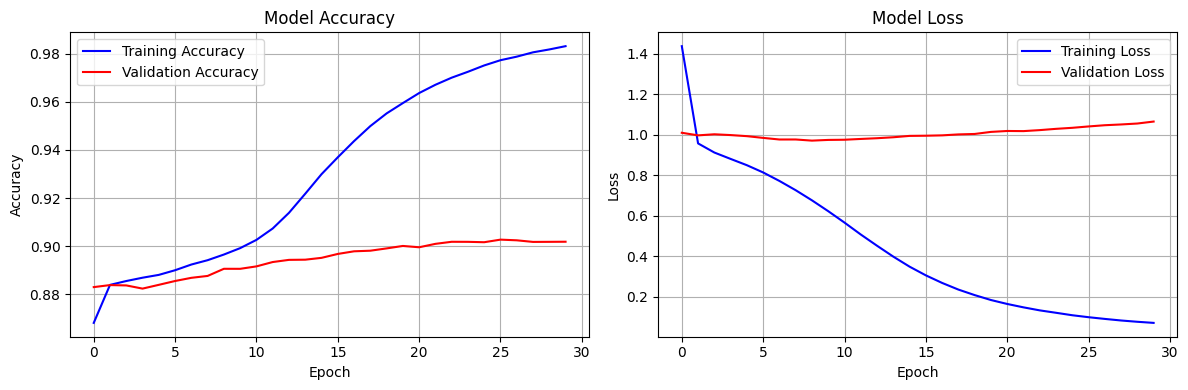

In [24]:
# -------------------------------
# 10. Plot Training History
# -------------------------------
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss', color='blue')
plt.plot(hist.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [25]:
# -------------------------------
# 11. Test Translation
# -------------------------------
print("\n" + "="*50)
print("TESTING TRANSLATIONS")
print("="*50)

# Test on some examples
test_sentences = [
    "Do you have a friend named Tom",
    "She called me in the afternoon.	",
    "I had nothing else to do."
]

for sentence in test_sentences:
    translation = translate_sentence(sentence)
    print(f"English: {sentence}")
    print(f"Arabic: {translation}")
    print("-" * 30)


TESTING TRANSLATIONS
English: Do you have a friend named Tom
Arabic: هل لديك صديق اسمه
------------------------------
English: She called me in the afternoon.	
Arabic: اتصلت بي بعد الظهر.
------------------------------
English: I had nothing else to do.
Arabic: لم يكن لديّ أيّ شيء آخر أقوم به.
------------------------------


In [26]:
model.save('translation_model.h5')
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

print("Models saved successfully!")

Models saved successfully!


In [27]:
!pip install gradio -q
import gradio as gr

In [29]:
def translate_gr(english_sentence):
    """Translate an English sentence to Arabic using the trained model."""
    return translate_sentence(english_sentence)

In [33]:
with gr.Blocks() as ui:
    gr.Markdown("# English to Arabic Translator")
    english_input = gr.Textbox(label="Enter English Sentence Here:")
    arabic_output = gr.Textbox(label="Translated Arabic Sentence:")
    translate_button = gr.Button("Translate")
    translate_button.click(translate_gr, inputs=english_input, outputs=arabic_output)

ui.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c3fbd0ed7e8384cbe1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7863 <> https://c3fbd0ed7e8384cbe1.gradio.live


In [30]:
iface = gr.Interface(
    fn=translate_gr,
    inputs=gr.Textbox(label="English Sentence"),
    outputs=gr.Textbox(label="Arabic Translation"),
    title="English to Arabic Translation",
    description="Translate English sentences to Arabic using a Seq2Seq Attention model."
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://642f58f9b4394ddbf3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
